### Introduction
Les **_"sytèmes de recommandation"_** sont une forme spécifique de filtrage de l'information dont le but est de présenter des éléments d'information (films, musique, livres, news, images, pages Web, etc) qui sont susceptibles d'intéresser l'utilisateur.

Généralement, un système de recommandation permet de comparer le profil d'un utilisateur à certaines caractéristiques de référence, et cherche à prédire l'« avis » que donnerait un utilisateur. Ces caractéristiques peuvent provenir de :

l'environnement social, on parle d'approche de filtrage collaboratif ou _"collaborative filtering"_.

***_Recommendation system collaborative based_***

Cette approche consiste à recommander des choses sur la base du comportement passé des utilisateurs similaires, en effectuant une corrélation entre des utilisateurs ayant des préférences et intérêts similaires. On  tentera de prédire ce que l'utilisateur aimera en cherchant des utilisateurs qui ont les mêmes comportements que l'utilisateur à qui l'on souhaite faire des recommandations. L'idée sous-jacente est de dire que si un personne A a la même opinion (ou les même goûts) qu'une personne B sur un objet x, alors la personne A a plus de chance d'avoir la même opinion que B sur un autre objet y, plutôt que d'avoir la même opinion que quelqu'un choisi au hasard pour l'objet y. 

In [172]:
%run load_preprocessing.ipynb

Importation des méthodes de clustering et de mesure de précision des estimateurs

In [173]:
from sklearn import metrics
from sklearn import cluster 

### Clustering
Nous décidons de lancer notre clustering , sur les genres des films car un clustering sur les notations peut etre biaisé par l'aléa de la subjectivité lors de la notation  par les utilisateurs

In [185]:
dbscan = cluster.DBSCAN(eps = 0.5 , min_samples = 14 ,  metric = 'euclidean', algorithm = 'brute')
dbscan.fit(movie_genre)
print("Labels of clusters hypthetically is : " +str(list(set(dbscan.labels_))))
#eps : distance minimale à laquelle se trouve le voisin le plus proche d'un point
#min_samples : nombre de clusters 
#metric : métrique de calcul de la distance
#algorithm : algorithme utilisé pour déterminer le plus proche voisin

#set : commande permettant de faire apparaitre les éléments au moins d'occurence 1 dans une liste

#movie_genre : matrice de 0 et 1 (0 si le film n'appartient pas au genre et 1 sinon)

#on remarquera qu'il y a 19 clusters soit autant que de genres diffèrents

Labels of clusters hypthetically is : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, -1]


#### Informations de bases sur notre base de données
Avant de continuer notre analyse il peut etre sage de vérifier une ou deux petites choses , par exemple : nombre de films notés pour chaque utilisateur..

In [186]:
from operator import itemgetter

lst_users = [rate.user_id  for rate in rating]
#lst_users : liste des utilisateurs contenus dans le fichier des notes
users_rates_items = [[x,lst_users.count(x)] for x in set(lst_users)]
#users_rate_items : listes de couples identifiant utilisateur et nombre d'occurences
users_rates_items.sort(key = itemgetter(1))
#users_rates_items : ordonnancement de la liste des couples en se basant sur le second element du couple
print("The user with the least amount of movies rated is :" +str(users_rates_items[0][0])+ " with " +str(users_rates_items[0][1]))
print("The user with the most amount of movies rated is :" +str(users_rates_items[len(users_rates_items)-1][0])+ " with " +str(users_rates_items[len(users_rates_items)-1][1]))


The user with the least amount of movies rated is :19 with 10
The user with the most amount of movies rated is :405 with 727


#### Moyennisation des notes par genres
Le but est d'aggrégé toutes les notes émises par un utilisateur dans les films d'un meme genre , chaque vecteur ligne de la matrice          $\mbox{utility matrix clustered}$ sera un vecteur des moyennes par genres de l utilisateur $i$ (ici l'idée est de d'estimer la proximité des gouts des utilisateurs dans chaque genre par leur moyennes , cette idée part de la constatation précèdente que tous les utilisateurs ne notent pas tous les films de chacun des genres..) 

In [129]:
utility_matrix_clustered = []
for i in range(0, n_users):
    average = np.zeros(19)
    tmp = []
    for index in range(0, 19):
        tmp.append([])
    for j in range(0, n_items):
        #avance dans l'algo si l'utilisateur a noté l'item
        if utility_matrix[i][j] != 0:
            #reunion des items du meme genre 
            tmp[dbscan.labels_[j] - 1].append(utility_matrix[i][j])
    for index in range(0, 19):
        if len(tmp[index]) != 0:
            #calcul de la moyenne
            average[index] = np.mean(tmp[index])
        else:
            average[index] = 0
    utility_matrix_clustered.append(average)
        

Dans cette étape nous stockons la note moyenne globalement accordé par chaque utilisateur dans toutes les classes (ici les genres)

In [165]:
utility_matrix_clustered = np.array(utility_matrix_clustered)
for i in range(0, n_users):
    umc = utility_matrix_clustered[i]
    #parcours de la matrice par lignes
    user[i].avg_r = sum(rate for rate in umc if rate > 0) / sum(rate > 0 for rate in umc)
    #stockage de la moyenne sur toutes les notes accordés

#### Mesure de similarité de la corrélation de Pearson

A l'inverse du score de la similarité de la distance euclidienne , la Pearson Correlation Measure
mesure la correlation (relation linéaire) entre deux variables sur un intervalle de -1 à 1 , (somme toute quel proximité ont deux variables sur le mm axe) :

-1 signifiant l'indépendance 

La cellule ci dessous reprend l'implémentation de la formule du coefficient en question qui est : 
$\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$

In [168]:
def pearson_correlation_similarity(x, y , ut):
    num = 0
    den1 = 0
    den2 = 0
    #ut representera la utility matrix clustered
    A = ut[x - 1]
    B = ut[y - 1]
    #correlation seulement calculer par la longueur du vecteur de l'utilisateur avec le moins de notes moyennes (en nombre)
    num = sum((a - user[x - 1].avg_r) * (b - user[y - 1].avg_r) for a, b in zip(A, B) if a > 0 and b > 0)
    den1 = sum((a - user[x - 1].avg_r) ** 2 for a in A if a > 0)
    
    den2 = sum((b - user[y - 1].avg_r) ** 2 for b in B if b > 0)
    
    den = (den1 ** 0.5) * (den2 ** 0.5)
    if den == 0:
        return 0
    else:
        return num / den
    
    #den1 : #calcul de l ecrat-type sur le vecteur x
    #den2 : #calcul de l ecart-type sur le vecteur y

De fait notre matrice d'analyse sera donc une matrice qui stocke à l'emplacement $(i,j)$ le coeffieint de corrélation de similarity de Pearson

In [132]:
pearson_correlation_similarity_matrix = np.zeros((n_users, n_users))
for i in range(0, n_users):
    for j in range(0, n_users):
        if i!=j:
            pearson_correlation_similarity_matrix[i][j] = pearson_correlation_similarity(i + 1, j + 1 , utility_matrix_clustered)
#le coefficient de correlation de Pearson est calculé sur les elements non diagonaux car elle serait a 1 (information non utile)

#### Normalisation des moyennes
Ici l'idée est de normaliser les moyennes dans le cas ou les notations auraient une variance signficative entre pair d'utilisateur considérés (dans le cas où on serait amené croiser un utilisteur avec que des notes à 1 et un autre avec sue des notes à 5 sur plus de 100 items)

In [133]:
def norm():
    normalize = np.zeros((n_users, 19))
    for i in range(0, n_users):
        for j in range(0, 19):
            if utility_matrix_clustered[i][j] != 0:
                normalize[i][j] = utility_matrix_clustered[i][j] - user[i].avg_r
    #faire la difference entre la moyenne d'un utilisateur pour un genre particulier et la note moyenne globale permet de centre 
    #la moyenne pour la ramener entre  0 et 1
            else:
                normalize[i][j] = float('Inf')
    return normalize

Avec la fonction que nous appelerons _"guess"_ nous ferons de la prédiction en essayant de deviner quel note pourrait accorder l'utilisateur $i$ au film avec l'identifiant $iid$ en servant de sa similarité (Pearson Correlation Similarity Measure) avec tous les autres utilisateurs

(dans un premier temps nous déroulerons la procédure pour tous les utilisateurs répertoriés , mais ensuite nous nous restreindrons à un certain $top$ $n$ classement d'utilisateurs similaires



In [134]:
def guess(user_id, i_id, top_n):
    similarity = []
    for i in range(0, n_users):
        if i+1 != user_id:
            similarity.append(pearson_correlation_similarity_matrix[user_id-1][i])
            #similarites  sont stockés par lignes , et arreter quand on arrive en dépassement d'indices
    temp = norm()
    temp = np.delete(temp, user_id-1, 0)
    #on efface les elements de la matrice egaux à zéros [on peut avoir acces a la matrice par position ou par indicage ligne 
    #on  a transfomé utility_matrix_clustered en array]
    top = [x for (y,x) in sorted(zip(similarity,temp), key=lambda pair: pair[0], reverse=True)]
    #reordonnement des similarites en ordre décroissant pour en récupérer les n premiers
    s = 0
    c = 0
    #si  l'une des "top" moyennes est inf on retourne directement la moyenne stocké de user_id pour le film i_id sinon
    #on retourne la moyenne des top n moyennes à condition qu'elle reste entre 1 et 5
    for i in range(0, top_n):
        if top[i][i_id-1] != float('Inf'):
            s += top[i][i_id-1]
            c += 1
    g = user[user_id-1].avg_r if c == 0 else s/float(c) + user[user_id-1].avg_r
    if g < 1.0:
        return 1.0
    elif g > 5.0:
        return 5.0
    else:
        return g

In [135]:
#deploiement de la méthode guess sur tous utilisateurs dans tous les genres , en se basant sur les top 150
utility_copy = np.copy(utility_matrix_clustered)
for i in range(0, n_users):
    for j in range(0, 19):
        if utility_copy[i][j] == 0:
            utility_copy[i][j] = guess(i+1, j+1, 150)

### Evaluation de la performance du clustering

##### prediction de la note pour u.test et calcul du MSE
Caclul de la somme des carrées des écarts entre ce qui est prédit et ce qui est estimé , le nombre calculer ici nous indique que notre estimateur est assez efficace et donc envisageable pour la suite de la construction (à supposer que l'on veuille encore ajouter d'autres options de ML à notre système de recommandation)

Petite vérification préliminaire avant de calculer l'homogénéité des clusters

In [192]:

genres = ["unknown", "action", "adventure", "animation","childrens", "comedy","crime", "documentary","drama", "fantasy", "film_noir", "horror",
           "musical", "mystery","romance", "sci_fi","thriller", "war", "western"]

movie_per_genre = pd.DataFrame(movie_genre)
movie_per_genre.columns = genres


numbers_genres_per_movie = list(map(lambda x : sum(x) , movie_genre))
#number_genres_per_movie : somme des cases différentes de zéros par lignes dans le dataframe 

print("Maximum number of genres where a movie can be is : " + str(max(numbers_genres_per_movie)))
movie_per_genre.head()

more_one_genres_movie = [x > 1 for x in numbers_genres_per_movie]

print(sum(more_one_genres_movie)/len(numbers_genres_per_movie))

Maximum number of genres where a movie can be is : 6
0.504756242568371


##### Calcul de l'homogeneité des clusters
Le pourcentage qui est calculé amènerait à ce poser des questions dans d'autres circonstances , mais il ne faut pas oublier qu'on part avec la spécifité qu'on essaie de _"fitter"_ dans des classes des items (films) dont certains appartiennent à plusieurs genres simultanément

In [195]:
metrics_comparison(dbscan.labels_)

#comme 50 pourcent des films sont répertoriés dans plus d'un genre et que l'homogénéité (pourcentage de films n'apparaissant que
#unique dans ce genre est de 25 pourcent on peut globalement estimer que notre estimateur à un taux de précision de 75 pourcent)
#ce qui est une bonne chose car on est au moins sur d'éviter l'overfitting

Mean Squared Error of the estimator is: 1.182537
Homogeneity is : 0.252728


### User Interface
Après avoir fait tous ces calculs (pensons à notre utilisateur qui ne sait toujours pas quoi regarder ce soir ;) )

il a été concu une mini UI (User interface) interragissant avec notre utilisateur pour lui communiquer quelques informations intéressantes..

On va associer les notes du nouvel utilisateur aux films notés et rapportés à leurs genres (dans le clustering) ainsi que calculer la moyenne donner au total dans tous les genres et déterminer ainsi l'utilisateur le plus proche au moyen de Pearson Correlation Measure



In [197]:
#Remplissage du formulaire par le nouvel utilisateur
#age
print("How old are you?")
age = input()
#sex
print("What is your gender?")
sex = input()
#occupation
print("What is your occupation?")
occupation = input()

print("how many movies do you want to rate?")
#nobmre de films qu'il désire noter
numb_movie = int(input())
#choix aléatoire du titre de film  qu'on propose à l'utilisateur de noter
ask = random.sample(item, numb_movie)
new_user = np.zeros(19)
average_new_user = 0
for movie in ask:
	print(movie.title + ": ")
	print(movie.imdb_url)
    #retour de l'url du film a l'utilisateur pour qu il puisse le voir avant de le noter
	a = int(input())
	average_new_user = average_new_user + a
	if new_user[dbscan.labels_[movie.id - 1]] != 0:
		new_user[dbscan.labels_[movie.id - 1]] = (new_user[dbscan.labels_[movie.id - 1]] + a) / numb_movie
#si on note aléatoirement par exempe deux films de deux genres différents la note accordé a chaque film sera considéré comme
#la note moyenne supposé du genre du dit film
        
	else:
		new_user[dbscan.labels_[movie.id - 1]] = a

utility_new = np.vstack((utility_copy, new_user))
#matrice verticale de deux colonnes (colonne 1 eventail des notes (sur 5) colonne 2 (note moyenne globale de chaque utilisateur))

new_user = User(944 , int(age) , sex , occupation , 110018)
user.append(new_user)

pearson_correlation_matrix = np.zeros(n_users)
list_averaging_users = []
print("Your average rate for all movies is :" +str(average_new_user/numb_movie))
#calcul de la note moyenne globale accordé à tous les films genres confondues 

#user similar
for i in range(0, n_users + 1):
    if i!=943:
        pearson_correlation_matrix[i] = pearson_correlation_similarity(944, i + 1  , utility_new)
#calcul de la similarité (coefficient de correlation de Pearson) entre la note moyenne globale du nouvel 
#utilisateur et celle des autres utilisateurs déja dans la base
        list_averaging_users.append(pearson_correlation_matrix[i])
    
index_max = max(enumerate(list_averaging_users),key=lambda x: x[1])[0]
#recuperation de l'identifiant de l'utilisateur dont le coeffiecent de correlation de pearson avec le nouvel utilisateur 
#est le plus élevé

print("The user similar to you is user number " +str(index_max))

user_similar = [" age : "+str(user[index_max].age) , "sex :" +str(user[index_max].sex) , "occupation:"+str(user[index_max].occupation)]
print(user_similar)


How old are you?
25
What is your gender?
M
What is your occupation?
student
how many movies do you want to rate?
2
Judgment Night (1993): 
http://us.imdb.com/M/title-exact?Judgment%20Night%20(1993)
3
Carpool (1996): 
http://us.imdb.com/M/title-exact?Carpool%20(1996)
2
Your average rate for all movies is :2.5
The user similar to you is user number 616
[' age : 27', 'sex :F', 'occupation:writer']


In [198]:
user_index = []
for i in user:
	user_index.append(i.id - 1)
user_index = user_index[:943]
user_index = np.array(user_index)

top = [x for (y,x) in sorted(zip(pearson_correlation_matrix, user_index), key=lambda pair: pair[0], reverse=True)]

numb = input("How many top genre do you want?")
numb = int(numb)
top = top[:numb]

#détermination des top genres en fonction de la hauteur du coefficient de correlation
#entre la note moyenne du nouvel utilisateur (dans un genre quelconque) et celle accordé par son utilisateur le plus simlaire
top_genre = []

for i in range(0, numb):
	maxi = 0
	maxe = 0
	for j in range(0, 19):
		if maxe < utility_matrix[top[i]][j]:
			maxe = utility_matrix[top[i]][j]
			maxi = j
	top_genre.append(maxi)

#typiquement les sorties seront les genres notés en commun ou tout simplement les mieux notés par votre similaire 
#(en ordre décroissnat)
print("Movie genres you'd like:")

for i in top_genre:
	if i == 0:
		print("unknown")
	elif i == 1:
		print("action")
	elif i == 2:
		print("adventure")
	elif i == 3:
		print("animation")
	elif i == 4:
		print("childrens")
	elif i == 5:
		print("comedy")
	elif i == 6:
		print("crime")
	elif i == 7:
		print("documentary")
	elif i == 8:
		print("drama")
	elif i == 9:
		print("fantasy")
	elif i == 10:
		print("film_noir")
	elif i == 11:
		print("horror")
	elif i == 12:
		print("musical")
	elif i == 13:
		print("mystery")
	elif i == 14:
		print("romance")
	elif i == 15:
		print("science fiction")
	elif i == 16:
		print("thriller")
	elif i == 17:
		print("war")
	else:
		print("western")

How many top genre do you want?2
Movie genres you'd like:
thriller
drama


#### Suggestion de films
Une fois que les caractéristiques de l'utilisateur du système ont été stockés , que les caractéristiques de l'utilisateur similaire ont été montrés ainsi que la suggestion des _"top genres"_  ont été fait , nous avons pensé qu'il serait judicieux de peut etre encore de suggérer à notre 
utilisateur du système de se faire une idée des films les mieux notés par son similaire

In [199]:
suggested_movies = max_rated_user_index_max(index_max, numb)
print("These are the top rated movies by your similar user , may take a quick look..")
print(suggested_movies)
#titres de films ayant recus la note maximale de la part de votre similaire (nombre entre 1 et numb
#[nombre de top genre suggérés])

These are the top rated movies by your similar user , may take a quick look..
                        movies
0  English Patient, The (1996)
1     L.A. Confidential (1997)


In [151]:
#### Représenation graphique des utilisateurs en fonction de leurs similarités par rapport à l'utilisateur du système
list_users = []
for usr in range(0,n_users):
    list_users.append([user[usr].sex , user[usr].age , user[usr].occupation , pearson_correlation_matrix[usr]])
    
df_users = pd.DataFrame(list_users)   
df_users.columns = ['sex' , 'age' , 'occupation' , 'similarity']

df_users.head()

,sex,age,occupation,similarity
0,M,24,technician,0.189522
1,F,53,other,0.014516
2,M,23,writer,0.048046
3,M,24,technician,0.231205
4,F,33,other,0.030563


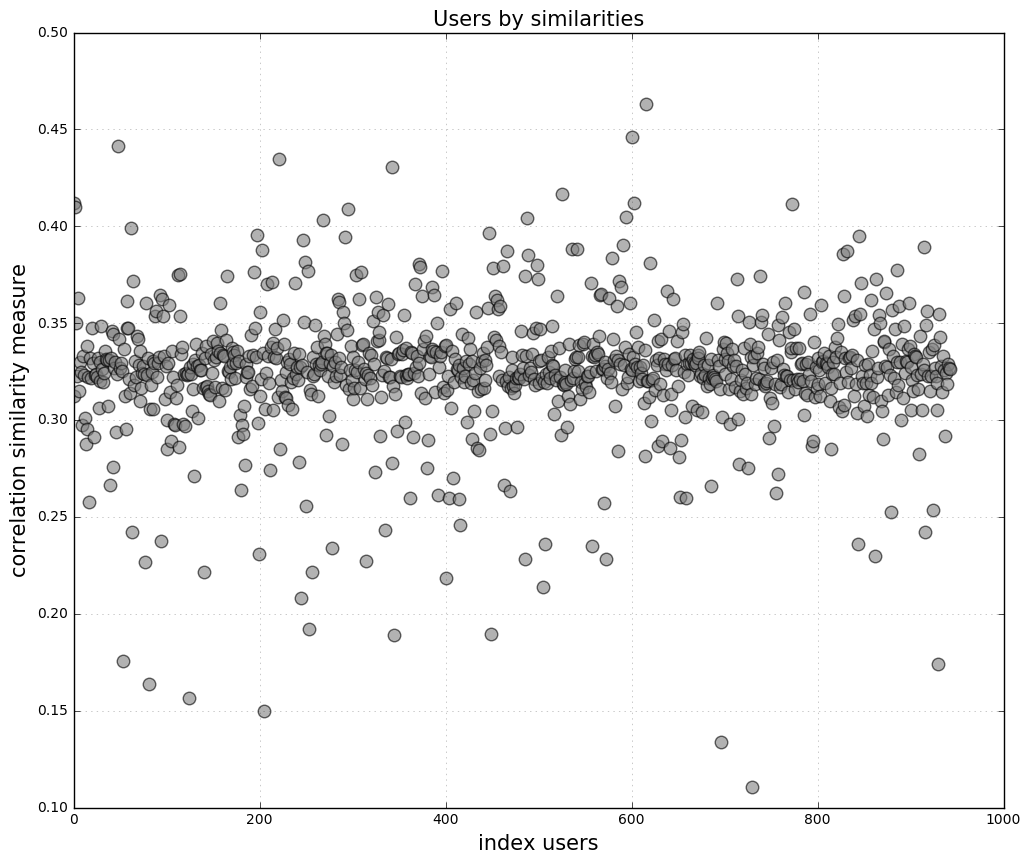

In [200]:
list_users = []
for usr in range(0,n_users):
    list_users.append([user[usr].sex , user[usr].age , user[usr].occupation , pearson_correlation_matrix[usr]])
    
df_users = pd.DataFrame(list_users)   
df_users.columns = ['sex' , 'age' , 'occupation' , 'similarity']

#dataframe listant les informations des utilisateurs

#dans un premier temps l idee était de faire un graphique interactif mais puisque il ne passait pas à l'enregistrement
#dans le notebook , je suis revenu à un graphique classique statique

fig = plt.gcf()
fig.set_size_inches(12, 10)



N = n_users
df = pd.DataFrame(index=range(N))
df['sex'] = df_users['sex']
df['age'] = df_users['age'] 
df['occupation'] = df_users['occupation']
df['similarity'] = df_users['similarity']

labels = []
for i in range(N):
    label = df.ix[[i], :].T
    label.columns = ['user :' + str(i)]
    labels.append(str(label.to_html()))



points = plt.plot(df.index,pearson_correlation_matrix, 'o', color='grey',
                 mec='k', ms=9, mew=1, alpha=.6)

plt.grid(True , alpha = 0.3)
plt.xlabel('index users' , size=15)
plt.ylabel('correlation similarity measure' , size=15)
plt.title('Users by similarities', size=15)
plt.show()
